# Year in Review &ndash; 2022  <a class="tocSkip">

Dan White < dan.white at libre.space >

Interesting stats about ground stations, satellites, and observations on the [SatNOGS Network](https://network.satnogs.org).

Source notebook at [github/wiredlab/scheduling-bazaar/notebooks](https://github.com/wiredlab/scheduling-bazaar/blob/master/notebooks/year-review-2022.ipynb)

TODO by request:

- [ ] sa2kng: how many stations has udp-dump-host set to other than null or unset (:
- [ ] 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Ground-Stations-database-setup" data-toc-modified-id="Ground-Stations-database-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Ground Stations database setup</a></span><ul class="toc-item"><li><span><a href="#Rotator-information" data-toc-modified-id="Rotator-information-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Rotator information</a></span></li></ul></li><li><span><a href="#Ground-Stations-Statistics" data-toc-modified-id="Ground-Stations-Statistics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Ground Stations Statistics</a></span><ul class="toc-item"><li><span><a href="#Popular-antenna-types" data-toc-modified-id="Popular-antenna-types-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Popular antenna types</a></span></li><li><span><a href="#Number-of-rotation-axes" data-toc-modified-id="Number-of-rotation-axes-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Number of rotation axes</a></span></li><li><span><a href="#Online-status" data-toc-modified-id="Online-status-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Online status</a></span></li><li><span><a href="#Ground-stations-created-by-year" data-toc-modified-id="Ground-stations-created-by-year-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Ground stations created by year</a></span></li></ul></li><li><span><a href="#Observations-database-setup" data-toc-modified-id="Observations-database-setup-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Observations database setup</a></span></li><li><span><a href="#Observations-Statistics" data-toc-modified-id="Observations-Statistics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Observations Statistics</a></span><ul class="toc-item"><li><span><a href="#Most-active-Observers" data-toc-modified-id="Most-active-Observers-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Most active Observers</a></span></li><li><span><a href="#High-utilization-and-large-averages" data-toc-modified-id="High-utilization-and-large-averages-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>High utilization and large averages</a></span></li><li><span><a href="#Popular-ground-stations" data-toc-modified-id="Popular-ground-stations-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Popular ground stations</a></span></li><li><span><a href="#Observer-diversity" data-toc-modified-id="Observer-diversity-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Observer diversity</a></span></li><li><span><a href="#Popular-satellites-this-year" data-toc-modified-id="Popular-satellites-this-year-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Popular satellites this year</a></span></li><li><span><a href="#Observers-with-satellite-fever" data-toc-modified-id="Observers-with-satellite-fever-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Observers with satellite fever</a></span></li><li><span><a href="#Stations-watching-all-the-sats" data-toc-modified-id="Stations-watching-all-the-sats-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Stations watching all-the-sats</a></span></li></ul></li><li><span><a href="#More-stats" data-toc-modified-id="More-stats-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>More stats</a></span><ul class="toc-item"><li><span><a href="#Your-turn!" data-toc-modified-id="Your-turn!-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Your turn!</a></span></li><li><span><a href="#Housekeeping" data-toc-modified-id="Housekeeping-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Housekeeping</a></span></li></ul></li></ul></div>

# Ground Stations database setup

In [1]:
%load_ext sql

In [2]:
%sql sqlite:///../data/stations.db

'Connected: @../data/stations.db'

First thing is to see whuzzup with this (SQlite) database.

In [3]:
%%sql
CREATE TABLE IF NOT EXISTS stations (
    id PRIMARY KEY,
    altitude REAL,
    antenna TEXT CHECK(json_valid(antenna)),  -- array of objects
    client_version TEXT,
    created TEXT,       --  YYYY-mm-ddTHH:MMZ
    description TEXT,
    last_seen TEXT,     --  YYYY-mm-ddTHH:MMZ
    lat REAL,
    lng REAL,
    min_horizon REAL,
    name TEXT,
    observations INT,
    qthlocator TEXT,
    status TEXT,
    target_utilization INT,
    rotator INT         -- 0, 1, or 2 axis rotation
    );

-- Then, add rows from the stations.json.  This was done via CSV import, but it should
-- be configured to directly ingest from the JSON in order to keep the DB up to date.


 * sqlite:///../data/stations.db
Done.
Done.


[]

The main table `stations` is just a copy of the data returned by the SatNOGS Network API endpoint https://network.satnogs.org/api/stations


<del>TODO: Automatically update the database from the API.</del> &rarr; See `python-files/update-stations`, which is called in the `data/do-updates.sh` script.

## Rotator information

The configuration for a ground station does not include machine-readable information about the antenna _mount_ -- how many axes of motion the antenna is moved about.
An omni-directional antenna affixed to a mast has 0 axes, while an azimuth + elevation rotator has 2 axes.
A single axis is also possible.

Notice from the schema for `stations` that there is one extra column, `rotator`, which will hold this information.
The problem is that we need to figure out the proper value to place in that field.

The `antenna` field holds a JSON array of objects holding information about the antennas attached to the particular station.

For example, the [main Valpo !WIREDlab station #834](https://network.satnogs.org/stations/834/) is configured with two antennas combined by a duplexer into a single RTL-SDR Blog v3 receiver.
The JSON array is then:

```json
"antenna": [
        {
            "frequency": 430000000,
            "frequency_max": 470000000,
            "band": "UHF",
            "antenna_type": "cross-yagi",
            "antenna_type_name": "Cross Yagi"
        },
        {
            "frequency": 135000000,
            "frequency_max": 150000000,
            "band": "VHF",
            "antenna_type": "cross-yagi",
            "antenna_type_name": "Cross Yagi"
        }
    ]
```

For our purposes here (inferring a correct `rotator` value), we focus on the object key `antenna_type`.

Extract the first item of the `antenna` array and summarize how many stations are using each type.

In [4]:
%%sql
-- Histogram of antenna types
SELECT
    json_extract(antenna, "$[0].antenna_type") as type,
    count(antenna) as num_type
FROM stations
GROUP BY type
ORDER BY num_type DESC;

 * sqlite:///../data/stations.db
Done.


type,num_type
turnstile,358
yagi,315
quadrafilar,291
vertical,251
cross-yagi,229
None,207
dipole,181
v-dipole,153
eggbeater,140
discone,140


Given these types of antennas, we can make a pretty good guess at which stations will have a rotator or not.
Omni-directional antenna types, e.g. turnstile and vertical, have no use for a rotator, while directional antennas such as yagi and helical likely would have a rotator.

Update the database to add these guesses.

In [5]:
guesses = (
    (0, "turnstile"),
    (2, "yagi"),
    (0, "quadrafilar"),
    (0, "vertical"),
    (2, "cross-yagi"),
    (0, "dipole"),
    (0, "v-dipole"),
    (0, "discone"),
    (0, "eggbeater"),
    (0, "other omni"),
    (2, "helical"),
    (0, "ground"),
    (0, "lindenblad"),
    (2, "other direct"),
    (2, "parabolic"),
    (0, "patch"),
    (0, "paralindy"),
)

for r, name in guesses:
    %sql UPDATE stations SET rotator = {r} \
         WHERE json_extract(antenna, "$[0].antenna_type") = "{name}";


 * sqlite:///../data/stations.db
358 rows affected.
 * sqlite:///../data/stations.db
315 rows affected.
 * sqlite:///../data/stations.db
291 rows affected.
 * sqlite:///../data/stations.db
251 rows affected.
 * sqlite:///../data/stations.db
229 rows affected.
 * sqlite:///../data/stations.db
181 rows affected.
 * sqlite:///../data/stations.db
153 rows affected.
 * sqlite:///../data/stations.db
140 rows affected.
 * sqlite:///../data/stations.db
140 rows affected.
 * sqlite:///../data/stations.db
92 rows affected.
 * sqlite:///../data/stations.db
80 rows affected.
 * sqlite:///../data/stations.db
69 rows affected.
 * sqlite:///../data/stations.db
38 rows affected.
 * sqlite:///../data/stations.db
35 rows affected.
 * sqlite:///../data/stations.db
18 rows affected.
 * sqlite:///../data/stations.db
10 rows affected.
 * sqlite:///../data/stations.db
5 rows affected.


Next up, recall that the station's name can contain useful information (FooName - fixed) along with the free-form Description text.

Set up a text search virtual table so we can look for text patterns:

In [6]:
%%sql
-- Setup for searching name, description fields for various text.
-- This is to find stations with different rotators than what may
-- be implied by their declared antenna_type(s)
CREATE VIRTUAL TABLE IF NOT EXISTS text 
USING FTS5(id, name, description);

INSERT OR REPLACE INTO text
SELECT id, name, description from stations;

 * sqlite:///../data/stations.db
Done.
2612 rows affected.


[]

Now let's look for stations where the **name** or **description** contain "fixed".

In [7]:
%%sql
-- Modify the rotator column to better reflect what the description claims
SELECT DISTINCT
    text.id,
    text.name,
    text.description,
    stations.antenna
FROM text, stations
WHERE text.id = stations.id
AND stations.rotator = 2
AND text MATCH 'fixed'
ORDER BY text.id;

 * sqlite:///../data/stations.db
Done.


id,name,description,antenna
66,KE8FZT - UHF,"Arrow UHF Corner Reflector, Fixed 20 Deg Elevation & Pointed 45 Deg NorthEast, AMSAT LNA,, MFJ Duplexer, Raspberry Pi3b","[{""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""VHF"", ""frequency"": 135000000, ""frequency_max"": 148000000}, {""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""UHF"", ""frequency"": 430000000, ""frequency_max"": 470000000}]"
212,KE8FZT - VHF,"Arrow VHF Corner Reflector, Fixed 20 Deg Elevation & Pointed 45 Deg NorthEast, LNA, Raspberry Pi3b","[{""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""VHF"", ""frequency"": 135000000, ""frequency_max"": 146000000}]"
1351,7el 70cm fixed Yagi,Restricted viewing angle is approximately 230 to 330 degrees.,"[{""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""UHF"", ""frequency"": 430000000, ""frequency_max"": 470000000}]"
1787,NCG,"Double bi-quad (13.46 dB) fixed position directional antenna looking e (W passes will not be seen well), altitude 48 deg, LNA (gain 20 dB noise 0.36dB), Lime, RPi 4","[{""antenna_type"": ""other direct"", ""antenna_type_name"": ""Other Directional"", ""band"": ""VHF, UHF"", ""frequency"": 130000000, ""frequency_max"": 600000000}]"
1810,NCG2,"V-dipole fixed, looking 90 deg E, LNA (gain 20dB noise 0.8dB), Lime, RPi","[{""antenna_type"": ""other direct"", ""antenna_type_name"": ""Other Directional"", ""band"": ""VHF"", ""frequency"": 135000000, ""frequency_max"": 148000000}]"
1868,HB9FXX S-Band,My little s-band station: 4G feed on fixed dish pointing roughly at 300° (WNW) and 30-45° elevation-> VLNA13 -> Coax -> 1.5GHz LPF -> HackRF SDR -> RPi 4 8GB. The HackRF uses a Leo Bodnar GPSDO mini reference. On a first floor balcony with mostly west opening. Not a terrible location but the best I can do living in a flat.,"[{""antenna_type"": ""parabolic"", ""antenna_type_name"": ""Parabolic"", ""band"": ""L, S"", ""frequency"": 1650000000, ""frequency_max"": 2400000000}]"
1950,KG7ZVV Satnogs,Fixed (no rotator) 10 element UHF Yagi. Visibility to only portion of sky towards Southwest. Apartments and building on other side.,"[{""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""UHF"", ""frequency"": 430000000, ""frequency_max"": 470000000}]"
2080,USU GAS Yagi Fixed SW,"Utah State University Get Away Special Team's second ground station. Wimo X-Quad (linear), No LNA currently. Fixed pointing SW at 45 deg elevation.","[{""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""UHF"", ""frequency"": 430000000, ""frequency_max"": 440000000}]"
2107,JH4XSY-pi,Pi4 + Airspy Mini + 3ele(145MHz)/6ele(435MHz) YAGI Fixed beam to the SouthWest.+ LNA,"[{""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""VHF"", ""frequency"": 135000000, ""frequency_max"": 148000000}, {""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""UHF"", ""frequency"": 420000000, ""frequency_max"": 450000000}]"
2246,HB9FXX S-Band 2,"Fixed dish at 300°, pointing like 30-40° up","[{""antenna_type"": ""parabolic"", ""antenna_type_name"": ""Parabolic"", ""band"": ""L, S"", ""frequency"": 1650000000, ""frequency_max"": 2500000000}]"


It looks like all the stations matching the query have directional antennas but have them mounted in various fixed orientations.
Eyeballing the descriptions, the antennas are at 20 to 45 degree elevation angles.

Update the `stations` table with this new information.

In [8]:
%%sql
UPDATE stations
SET rotator = 0
WHERE id IN (66, 212, 1351, 1787, 1810, 1868, 1950, 2080, 2107, 2246, 2263,     
             2372, 2430, 2501, 2650);

 * sqlite:///../data/stations.db
15 rows affected.


[]

Now look for text that indicates a rotator model.
Popular units are the Yaesu G-5500 and the Alfa SPID.

In [9]:
%%sql
-- Find another pattern that implies a rotator
SELECT DISTINCT
    text.id,
    text.name,
    text.description,
    stations.antenna,
    stations.rotator
FROM text, stations
WHERE text.id = stations.id
AND text MATCH '5500 OR spid'
AND rotator <> 2
ORDER BY text.id;


 * sqlite:///../data/stations.db
Done.


id,name,description,antenna,rotator
888,CCERES,Directionnal WIMO VHF 10 elements and WIMO UHF 18 elements crossed yagi antennas + circular polarization coupler + UHF MVV70cm LNA + Diplexer 2m/70cm + SDR Airspy R2. Rotator : Yaesu G-5500 + GS-232B. Actually no have LNA for VHF antenna.,"[{""antenna_type"": ""quadrafilar"", ""antenna_type_name"": ""Quadrafilar"", ""band"": ""UHF"", ""frequency"": 430000000, ""frequency_max"": 440000000}, {""antenna_type"": ""cross-yagi"", ""antenna_type_name"": ""Cross Yagi"", ""band"": ""VHF"", ""frequency"": 135000000, ""frequency_max"": 150000000}]",0
2500,Wolfgang HB9RYZ,Swiss Amateur Radio Station (JN47FE). Building up a brand new Ground Station in Q1/2022 with two Wimo X-Quad Antennas for 2m and 70cm including pre-amps and a SPID-RAS rotor. Temp.: running a Diamond vertical X-50NA (2m/70cm) on top of my roof. www.hb9ryz.ch,"[{""antenna_type"": ""vertical"", ""antenna_type_name"": ""Vertical"", ""band"": ""VHF"", ""frequency"": 135000000, ""frequency_max"": 148000000}, {""antenna_type"": ""vertical"", ""antenna_type_name"": ""Vertical"", ""band"": ""UHF"", ""frequency"": 430000000, ""frequency_max"": 470000000}]",0


And update the `rotator` field.
Note that this was tagged with `rotator = 0` since we only looked at the _first_ item in the `antenna` JSON array.

In [10]:
%%sql
UPDATE stations SET rotator = 2 WHERE id IN (888, 2500);

 * sqlite:///../data/stations.db
2 rows affected.


[]

Keep searching for keywords in the descriptions.

In [11]:
%%sql
SELECT DISTINCT
    text.id,
    text.name,
    text.description,
    stations.antenna,
    stations.rotator
FROM text, stations
WHERE text.id = stations.id
AND text MATCH 'azimuth'
ORDER BY text.id;


 * sqlite:///../data/stations.db
Done.


id,name,description,antenna,rotator
357,ce3vna,estacion completa de radioaficionados con rotor de azimuth y elevacion,"[{""antenna_type"": ""ground"", ""antenna_type_name"": ""Ground Plane"", ""band"": ""VHF"", ""frequency"": 135000000, ""frequency_max"": 148000000}, {""antenna_type"": ""ground"", ""antenna_type_name"": ""Ground Plane"", ""band"": ""UHF"", ""frequency"": 430000000, ""frequency_max"": 440000000}]",0
1146,Ham Radio Ground Station,Ground station project specifically designed for communication with small satellites in Low Earth Orbit using VHF and UHF amateur radio frequencies and provide hands-on educational projects in the world The ground station can autonomously track satellites by using these equipments : VHF / UHF amateur radio transceiver (Amateur bands 144-16 MHZ and 430-440 MHZ) Rotator Controller Azimuth and elevation rotators UHF and VHF Yagi antennas (Amateur bands 144-16 MHZ and 430-440 MHZ) Modems...,[],2
1775,Vi3w Roy4l,"Dual-Band Log Periodic Antenna or LPDA (log-periodic dipole array) VHF/UHF. 2 Meter gain is 6.8 dbd (8.9 dBi) and 440 Gain is 7 dBd (9 dBi). Set up on a 360° Rotator, Azimuth only with a set angle of 30°. The Azimuth changes from time to time when manually scheduling for Satellites on the Polar Plot. Rpi 3B+, RTL-SDR + RTL-LNA. Trying this all out and we'll see what happens, 1st Station on the Island. July: Added a Rotator Wifi controller on the LAN/WAN to control the Rotator on/off site.","[{""antenna_type"": ""other direct"", ""antenna_type_name"": ""Other Directional"", ""band"": ""VHF"", ""frequency"": 136000000, ""frequency_max"": 148000000}, {""antenna_type"": ""other direct"", ""antenna_type_name"": ""Other Directional"", ""band"": ""UHF"", ""frequency"": 400000000, ""frequency_max"": 429000000}, {""antenna_type"": ""other direct"", ""antenna_type_name"": ""Other Directional"", ""band"": ""UHF"", ""frequency"": 430000000, ""frequency_max"": 470000000}]",2
2221,Francis Ground Station,Antenna array of 2 elements yagi for UHF Antenna dish and S-Band The Antenna array is attached to the edge of the dish of the S-Band Antenna The Antenna has a servo motor that controls azimuth and another for elevation,[],2


Two more stations with rotators.

AND a station with an azimuth-only axis!

In [12]:
%%sql
UPDATE stations SET rotator = 2 WHERE id IN (357, 1146, 2221);

-- And an azimuth-only station!
UPDATE stations SET rotator = 1 WHERE id IN (1775);

 * sqlite:///../data/stations.db
3 rows affected.
1 rows affected.


[]

Keep looking.  Searching for "azimuth" yielded nice results, so search for "elevation" next.

In [13]:
%%sql
SELECT DISTINCT
    text.id,
    text.name,
    text.description,
    stations.antenna,
    stations.rotator
FROM text, stations
WHERE text.id = stations.id
AND text MATCH 'elevation'
AND stations.rotator <> 0
ORDER BY text.id;


 * sqlite:///../data/stations.db
Done.


id,name,description,antenna,rotator
146,RIYADH2,31 Oct 2020 moved down street - 90 degree elevation crossed Yagi+LNA 13 feb 2021 - wire antenna back - UHF LNA 27 feb 2021 - short cross yagi looking up 25 Sep 2022 - new location down the road - just monopole and no LNA - 3 stories 22 Oct 2022 - UHF Yagi looking straight up with LNA,"[{""antenna_type"": ""cross-yagi"", ""antenna_type_name"": ""Cross Yagi"", ""band"": ""UHF"", ""frequency"": 400000000, ""frequency_max"": 470000000}]",2
484,DParabole,Paris La Villette. Antenna is currently blocked at 90deg elevation,"[{""antenna_type"": ""helical"", ""antenna_type_name"": ""Helical"", ""band"": ""L"", ""frequency"": 1500000000, ""frequency_max"": 1750000000}]",2
1146,Ham Radio Ground Station,Ground station project specifically designed for communication with small satellites in Low Earth Orbit using VHF and UHF amateur radio frequencies and provide hands-on educational projects in the world The ground station can autonomously track satellites by using these equipments : VHF / UHF amateur radio transceiver (Amateur bands 144-16 MHZ and 430-440 MHZ) Rotator Controller Azimuth and elevation rotators UHF and VHF Yagi antennas (Amateur bands 144-16 MHZ and 430-440 MHZ) Modems...,[],2
1312,ESOC UHF,"437MHz Wimo cross yagi, phasing cable combiner, NooElec NESDR SMArt SMA 100700 RTL-SDR. V3.01 Satnogs Rotator, 3D printed elevation shafts, Raspberry Pi 3b. Radio Club + Cybernetics Club at ESA Space Operation Centre, Darmstadt.","[{""antenna_type"": ""cross-yagi"", ""antenna_type_name"": ""Cross Yagi"", ""band"": ""UHF"", ""frequency"": 430000000, ""frequency_max"": 470000000}]",2
1423,OLIVIER F6OBT,"Rpi 4 + 1 Yagis antenna VHF 3 elements direction N-E, 1 Yagis antenna VHF 3 elements direction N-W and 1 Yagis antenna UHF 5 elements direction N-W, 1 Yagis antenna UHF 5 elements direction N-E. All antennas have an elevation angle of 40°.","[{""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""VHF"", ""frequency"": 135000000, ""frequency_max"": 152000000}, {""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""UHF"", ""frequency"": 400000000, ""frequency_max"": 500000000}]",2
1466,PE0SAT-12,"HP NC6400 Laptop, Intel T7200 | Debian Bullseye (amd64) | SDR RX: AirSPY R2 | Antenna: DK7ZB 9 Element Yagi Pointing bearing 315 / elevation 75.","[{""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""UHF"", ""frequency"": 400000000, ""frequency_max"": 470000000}]",2
1640,VA7EEX - UHF,"Log periodic antenna with a 60 degree elevation, pointed southwest.","[{""antenna_type"": ""other direct"", ""antenna_type_name"": ""Other Directional"", ""band"": ""UHF"", ""frequency"": 400000000, ""frequency_max"": 512000000}]",2
1710,EU1AEM,"In maintenance now! 3-element yagi, vertical polarization, directed to east (100°), elevation 25° -> Uputronix 433-438 MHz filtred preamp -> RTL-SDR v3 -> Raspberry Pi 4. Please, do not use this station for west passes. Antenna is directed to east. Use station #2029 for west passes.","[{""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""UHF"", ""frequency"": 433000000, ""frequency_max"": 439000000}]",2
1789,jchem,"RPi4 + preamp 20dB + sdrrtl-v3, with VHF-4el.-horizontal-yagi pointing NE at 35° elevation. (if UHF: )two UHF-Yagi_6-el, 180d apart at 40d elevation, di. NE-SW.","[{""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""VHF"", ""frequency"": 135000000, ""frequency_max"": 148000000}]",2
2029,EU1AEM,"In maintenance now! 3-element yagi, vertical polarization, directed to west (270°), elevation 30° -> Uputronix 433-438 MHz filtred preamp -> RTL-SDR v3 -> Raspberry Pi 4. Please, do not use this station for east passes. Antenna is directed to west. Use station #1710 for east passes.","[{""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""UHF"", ""frequency"": 433000000, ""frequency_max"": 439000000}]",2


... and found some more stations with directional antennas but with fixed pointing.

In [14]:
%%sql
-- More no-rotator stations
UPDATE stations SET rotator = 0 WHERE id IN (146, 484, 1423, 1466, 1640, 1710, 1789, 2029)

 * sqlite:///../data/stations.db
8 rows affected.


[]

It is interesting to note the stations with capabilites that are different than presumed.
Such a diversity of setups!

How about looking for a word meaning an exception such as "only"?

In [15]:
%%sql
SELECT DISTINCT
    text.id,
    text.name,
    text.description,
    stations.antenna,
    stations.rotator
FROM text, stations
WHERE text.id = stations.id
AND text MATCH 'only'
AND stations.rotator <> 0
ORDER BY text.id;


 * sqlite:///../data/stations.db
Done.


id,name,description,antenna,rotator
36,oe8rke,"2022-04-03: station close being reopend after rotor replacement 2019-12-19: Still experiance issues with rotor - PLEASE ONLY EMERGENCY RECEPTIONS UNTIL ROTOR IS BACK, TNX! 2019-12-10: Shutdown to service rotor again (stall issue), offsite location in the alps with low noise, operating with pstrotator hamlib interface","[{""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""UHF"", ""frequency"": 430000000, ""frequency_max"": 470000000}, {""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""VHF"", ""frequency"": 144000000, ""frequency_max"": 146000000}, {""antenna_type"": ""helical"", ""antenna_type_name"": ""Helical"", ""band"": ""S"", ""frequency"": 2300000000, ""frequency_max"": 2450000000}, {""antenna_type"": ""helical"", ""antenna_type_name"": ""Helical"", ""band"": ""L"", ""frequency"": 1230000000, ""frequency_max"": 1290000000}]",2
87,M0IEB/M,"15.04.2018, Testing software with temporary home rig location, 23.04.2018, Home rig set, added LNA and filter for 145M band. Enjoy! 26.04.2018, Rig won't get 137M, 07.05.2018, Updated to 0.6.1, In case it was not clear, this station will not receive NOAA. 29.08.2018, now sitting in Surrey Space Centre temporarily. 14.12.2018: Tracking ESEO only on UHF, no tracking available for other sats. 08.02.2019: Added ISS for ARISS SSTV Event. 27.06.2019: Tracking ESA ESEO. From Nov 2019, tracking OPS-SAT.","[{""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""UHF"", ""frequency"": 430000000, ""frequency_max"": 470000000}, {""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""VHF"", ""frequency"": 135000000, ""frequency_max"": 146000000}]",2
254,SP2ZIE - 70cm,Rotator damaged. PW-SAT2 Satellite only. 435.275MHz+/-25kHz bandpass filter. AZ-EL Wimo WX7036. High noise environment. 437-438MHz strong QRMs from LoRa like transmissions. Band limited to 435MHz-440MHz (bandpass filter). Test setup.,"[{""antenna_type"": ""cross-yagi"", ""antenna_type_name"": ""Cross Yagi"", ""band"": ""UHF"", ""frequency"": 432000000, ""frequency_max"": 439000000}]",2
527,Test1,This is only a test for a system later on,"[{""antenna_type"": ""helical"", ""antenna_type_name"": ""Helical"", ""band"": ""L"", ""frequency"": 1600000000, ""frequency_max"": 1800000000}, {""antenna_type"": ""helical"", ""antenna_type_name"": ""Helical"", ""band"": ""L"", ""frequency"": 1500000000, ""frequency_max"": 1750000000}]",2
959,CE3VRT - VHF - UHF,Station on rural area (limited internet access). Please try to schedule Fox series sats only. Gear: - VHF Turnstile - FM Filter + LNA4ALL - Nooelec RTLSDR,"[{""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""UHF"", ""frequency"": 430000000, ""frequency_max"": 470000000}]",2
1287,FOSSA-STATION,"Test Tape Measure Yagi, Only North/West Passes","[{""antenna_type"": ""yagi"", ""antenna_type_name"": ""Yagi"", ""band"": ""UHF"", ""frequency"": 430000000, ""frequency_max"": 470000000}]",2
1526,Budapest UHF (west only),"2*3el UHF cross yagi facing 270deg AZ 45deg EL. Setup: Orange Pi Zero 256M, LimeSDR Mini, diy filter with ~2dB loss, SPF5043Z ~0.6NF 20dB LNA, diy antenna. Contact me on the community forms if you have any questions.","[{""antenna_type"": ""cross-yagi"", ""antenna_type_name"": ""Cross Yagi"", ""band"": ""UHF"", ""frequency"": 430000000, ""frequency_max"": 440000000}]",2
1594,VK2PET #2 Trial Station,This station is a Trial to play around with antennas & SDR's. It will NOT be online all the time. Limited by myself entering the Satellite passes into PST-Rotator. Back online for testing only as I'm having a lot of issues with this station. For all others please use my other station.,"[{""antenna_type"": ""other direct"", ""antenna_type_name"": ""Other Directional"", ""band"": ""VHF"", ""frequency"": 135000000, ""frequency_max"": 148000000}, {""antenna_type"": ""other direct"", ""antenna_type_name"": ""Other Directional"", ""band"": ""UHF"", ""f

Jackpot!
A few more stations with directional antennas but no rotation.

And a bonus azimuth-only station!

In [16]:
%%sql
-- More no-rotator stations
UPDATE stations SET rotator = 0 WHERE id IN (1526, 1824, 2482);

-- And another azimuth-only station!
UPDATE stations SET rotator = 1 WHERE id IN (2837);

 * sqlite:///../data/stations.db
3 rows affected.
1 rows affected.


[]

That's good enough for now.
Note to self to consider filing an issue against the ground station information endpoint to add a field to capture this number of axes directly from the owner.

What about the stations with an empty `antenna` field?

In [17]:
%%sql
SELECT
    count(*),
    sum(observations)
FROM stations
WHERE rotator NOT IN (0, 1, 2) or rotator IS NULL;

 * sqlite:///../data/stations.db
Done.


count(*),sum(observations)
205,47


So there are 205 stations with a blank `antenna` field, which have scheduled a total of only 47 observations across them.
It is not statistically useful to attempt to classify the number of rotation axes for these stations.

# Ground Stations Statistics

## Popular antenna types

In [18]:
%%sql
SELECT
    json_extract(antenna, "$[0].antenna_type") as type,
    count(antenna) as num_type
FROM stations
GROUP BY type
ORDER BY num_type DESC;

 * sqlite:///../data/stations.db
Done.


type,num_type
turnstile,358
yagi,315
quadrafilar,291
vertical,251
cross-yagi,229
None,207
dipole,181
v-dipole,153
eggbeater,140
discone,140


## Number of rotation axes

In [19]:
%%sql
-- Number of stations by motion axes
SELECT
    rotator,
    count(rotator) as num,
    round(100.0 * count(rotator) / (SELECT count(*) FROM stations), 1) as percent
FROM stations
GROUP BY rotator
ORDER BY rotator;

 * sqlite:///../data/stations.db
Done.


rotator,num,percent
None,0,0.0
0,1751,67.0
1,2,0.1
2,654,25.0


Of the registered ground stations, the ratio of locations with no rotator versus some rotator is about 70 % to 30 %.

What if we restrict this to stations which are presently operating as either "Online" or "Testing"?

In [20]:
%%sql
-- Number of stations by motion axes
SELECT
    rotator,
    count(rotator) as num,
    round(100.0 * count(rotator) / (select count(*) from stations WHERE status IN ("Online", "Testing")), 1) as percent
    -- Can't figure out how to reuse the WHERE clause without just repeating it, please help!
FROM stations
WHERE status IN ("Online", "Testing") -- Only other option is "Offline"
GROUP BY rotator
ORDER BY rotator;


 * sqlite:///../data/stations.db
Done.


rotator,num,percent
None,0,0.0
0,308,77.0
1,2,0.5
2,89,22.3


The ratio increases in favor of no rotator for the antenna (or merely omni-directional).

## Online status

In [21]:
%%sql
-- Number of stations by motion axes
SELECT
    status,
    count(status) as num,
    round(100.0 * count(status) / (select count(*) from stations), 1) as percent
FROM stations
GROUP BY status
ORDER BY num DESC;

 * sqlite:///../data/stations.db
Done.


status,num,percent
Offline,2212,84.7
Online,266,10.2
Testing,134,5.1


About 15% of registered ground stations are presently operating and ready to accept observation jobs.

## Ground stations created by year

In [22]:
%%sql
SELECT
    strftime("%Y", created) as year,
    count(id) as num_new
FROM stations
WHERE strftime("%s", created) >= strftime("%s", printf("%d-01-01", year))
  AND strftime("%s", created) <  strftime("%s", printf("%d-01-01", year+1))
GROUP BY year
ORDER BY year;


 * sqlite:///../data/stations.db
Done.


year,num_new
2015,4
2016,1
2017,25
2018,349
2019,700
2020,608
2021,498
2022,426
2023,1


# Observations database setup

I make a nightly mirror of the observations on Network and store in a SQlite database for fast local queries, like this.
It can miss changes made to observations made many days afterwards, so this information is not 100% accurate.

In [23]:
%sql sqlite:///../data/observations.db

'Connected: @../data/observations.db'

In case we dropped the indexes for some reason, add them back.

In [24]:
%%sql
-- Indexes make the world go 'round ... faster.
CREATE INDEX IF NOT EXISTS gs_norad_index
ON observations(ground_station, norad_cat_id);

CREATE INDEX IF NOT EXISTS gs_index
ON observations(ground_station);

CREATE INDEX IF NOT EXISTS norad_index
ON observations(norad_cat_id);

CREATE INDEX IF NOT EXISTS observer_index
ON observations(observer);

CREATE INDEX IF NOT EXISTS observer_gs_index
ON observations(observer, ground_station);

CREATE INDEX IF NOT EXISTS gs_observer_index
ON observations(ground_station, observer);


 * sqlite:///../data/observations.db
   sqlite:///../data/stations.db
Done.
Done.
Done.
Done.
Done.
Done.


[]

We will also be doing lots of time range filtering, which will benefit from an R\*tree.
The "`+`" prefix is an auxiliary column to make many queries faster by avoiding an extra search of the huge `observations` table.

In [25]:
%%sql
-- Special index for speeding up time range queries.
CREATE VIRTUAL TABLE IF NOT EXISTS times_index
USING rtree(
        id,
        start,
        end,
        +ground_station INT,
        +observer INT,
        +norad_cat_id INT);

-- (commented out since it takes a long time, and is only needed once anyway)
-- (un-comment if this is your first time)
-- INSERT OR REPLACE INTO times_index
-- SELECT
--     id,
--     strftime("%s", start),
--     strftime("%s", end),
--     ground_station,
--     observer,
--     norad_cat_id
-- FROM observations
-- WHERE strftime("%s", start) <= strftime("%s", end);

 * sqlite:///../data/observations.db
   sqlite:///../data/stations.db
Done.
Done.


[]

Since this is a special table and not an index, we need to keep the table up to date when the main `observations` table changes.
So, add some triggers for ADD, UPDATE, and DELETE events.

In [26]:
%%sql
-- Add triggers to keep the times Rtree updated

CREATE TRIGGER IF NOT EXISTS times_insert_trigger
AFTER INSERT
ON observations
WHEN strftime("%s", NEW.start) <= strftime("%s", NEW.end)  -- sanity check
BEGIN
    INSERT OR REPLACE INTO times_index(
            id,
            start,
            end,
            ground_station,
            observer,
            norad_cat_id)
    VALUES (NEW.id,
            strftime("%s", NEW.start),
            strftime("%s", NEW.end),
            NEW.ground_station,
            NEW.observer,
            NEW.norad_cat_id);
END;


CREATE TRIGGER IF NOT EXISTS times_update_trigger
AFTER UPDATE
ON observations
WHEN strftime("%s", NEW.start) <= strftime("%s", NEW.end)
BEGIN
    INSERT OR REPLACE INTO times_index(
            id,
            start,
            end,
            ground_station,
            observer,
            norad_cat_id)
    VALUES (NEW.id,
            strftime("%s", NEW.start),
            strftime("%s", NEW.end),
            NEW.ground_station,
            NEW.observer,
            NEW.norad_cat_id);
END;

CREATE TRIGGER IF NOT EXISTS times_delete_trigger
AFTER DELETE
ON observations
BEGIN
    DELETE FROM times_index
    WHERE id = OLD.id;
END;

 * sqlite:///../data/observations.db
   sqlite:///../data/stations.db
(sqlite3.OperationalError) incomplete input
[SQL: -- Add triggers to keep the times Rtree updated

CREATE TRIGGER IF NOT EXISTS times_insert_trigger
AFTER INSERT
ON observations
WHEN strftime("%s", NEW.start) <= strftime("%s", NEW.end)  -- sanity check
BEGIN
    INSERT OR REPLACE INTO times_index(
            id,
            start,
            end,
            ground_station,
            observer,
            norad_cat_id)
    VALUES (NEW.id,
            strftime("%s", NEW.start),
            strftime("%s", NEW.end),
            NEW.ground_station,
            NEW.observer,
            NEW.norad_cat_id);]
(Background on this error at: https://sqlalche.me/e/14/e3q8)


^^^ So these statements were copied directly from my development version.
Not sure what the error is, but for analysis, the triggers don't make a difference anyway.  #wontfix

# Observations Statistics

Let's cross-check a number against the official database for first three ground stations that I operate:
https://network.satnogs.org/users/wiredlab/

In [27]:
%%sql
SELECT
    ground_station,
    count(*) as num
FROM observations
WHERE ground_station IN (834, 841, 890)
GROUP BY ground_station;

 * sqlite:///../data/observations.db
   sqlite:///../data/stations.db
Done.


ground_station,num
834,14070
841,818
890,855


The total for #834 is lower than the 14367 reported on the website, about 2% too low, while the other two match exactly.
Is this a problem?  I do know that my SQlite version isn't an exact mirror.  Perhaps a bug in how I've pulled the observations list from the API.
In any case, we'll make note of the discrepancy and proceed with caution.

## Most active Observers

Which users have done the most scheduling across the Network?

Shout out to @sfou for adding the observer to the API endpoint recently: https://gitlab.com/librespacefoundation/satnogs/satnogs-network/-/issues/868,
or much of this analysis would not have been possible.

In [28]:
%%sql
-- EXPLAIN QUERY PLAN
SELECT
    observer,
    count(distinct ground_station) AS num_gs,
    count(id) AS num_obs,
    ground_station
FROM times_index
WHERE start >= strftime("%s", "2022-01-01")
    AND start <  strftime("%s", "2023-01-01")
GROUP BY observer
ORDER BY num_obs DESC
LIMIT 10;

 * sqlite:///../data/observations.db
   sqlite:///../data/stations.db
Done.


observer,num_gs,num_obs,ground_station
172,492,114450,1650
2740,166,91709,2051
1394,2,88821,704
3000,212,74776,1864
326,1,58961,91
3345,37,57493,2380
1501,1,57393,766
968,21,53185,1466
3122,2,44933,1936
2727,2,40501,1667


In [29]:
result = _

Notice how that query only touches the R\*tree `times_index` virtual table?
This is why we added the auxiliary columns!
The version that uses both `times_table` to find observations from only 2022 and then references `observations` for the rest of the information takes twice as long (15 versus 7 seconds).

Even in the top 10 observers there is a nearly 3:1 span of numbers for the year.
The handful of active observers are _really_ active.
We'll look at the "typical" observer shortly.

Before we get too deep into this analysis, I don't presently have the mapping between observer IDs and the name associated with the account.
This information is available if you're willing to find an observation with the observer of interest, go to that observation's web page, then parse the page to see the observer's user name.
Note to self: open an issue to expose the /users endpoint via the API so we can automate this lookup.
Would then also be useful for stats like "how many ground stations does a user own?"
Until then, we'll be content with not naming names and just looking at trends and such.

Some IDs that I do know and are relevant:

| ID | name | note
|--|--|--|
| 172 | BOCTOC-1 | The Human AutoScheduler :)
| 173 | fredy | SatNOGS ops team lead
| 1542 | wiredlab | me
| 2735 | satnogs-auto | Auto Scheduler

The `num_gs` column from the last query shows that, even among the most active SatNOGS users scheduling observations, some people schedule on many ground stations while others schedule solely on (presumably) their own station.

(the `ground_station` column is only useful when `num_gs == `)

Observer 326 scheduled the most observations on a single station.
A SatNOGS station can only observe one satellite at a time, so this number seems high?
Really, we (I) don't have a good point of reference for this 59k number, so let's see what the average time between starts this represents.

In [30]:
idx = [i for i, r in enumerate(result) if r[0] == 326][0]
observer, num_obs = result[idx][0:3:2]
observer, num_obs

(326, 58961)

In [31]:
min_in_year = 60 * 24 * 365

avg = min_in_year / num_obs
print(f"{avg:.1f} minutes, average time between observation starts")

8.9 minutes, average time between observation starts


Ok, so there were an average of about 9 minutes between observations on this particular ground station

In [32]:
%%sql
-- obs time for one station
SELECT
    ground_station,
    count(id) AS num_obs,
    round(sum(end - start)/60.0, 2) AS obs_min
FROM times_index
WHERE ground_station = 91
    AND start >= strftime("%s", "2022-01-01")
    AND start <  strftime("%s", "2023-01-01")
;

 * sqlite:///../data/observations.db
   sqlite:///../data/stations.db
Done.


ground_station,num_obs,obs_min
91,59955,565239.47


In [33]:
result = _

In [34]:
obs_min = result.dict()['obs_min'][0]

print(f'{obs_min:7.1f} minutes in observations')
print(f'{min_in_year:7.1f} minutes in a year')
utilization = (obs_min / min_in_year) * 100
print(f'{utilization:.1f} % utilization')

565239.5 minutes in observations
525600.0 minutes in a year
107.5 % utilization


??? This means the station had more minutes of observation time during the year than there are minutes in a year???

100 % utilization seems to be the best anyone can do, so it's not obvious what the problem is.
Perhaps many of these observations were not finished?
Or the query or my database is incorrect in some way?
Or maybe the API for scheduling an observation has a bug that would allow this?

Seems worth investigation to see what observations overlap.

## High utilization and large averages

I know enough number theory to know that a brute force search across all the observations to find overlaps is **59955 choose 2** comparisons.
A better algorithm can vastly reduce this computation, but that will be _left as an exercise for the reader_.&star;

&star; &ndash; I hated this phrase as a student, now that I'm "on the other side," I still don't like it.  The issue will probably bug me until I _do_ that exercise :)

To get a sense of this, take a look at the summary plot for this ground station (91) from the notebook that I periodically update: [scheduling-status.ipynb](https://github.com/wiredlab/scheduling-bazaar/blob/master/notebooks/observations-status.ipynb).
Scroll way down to the bottom for the plots for individual stations.

Here is a screenshot of the station's activity:

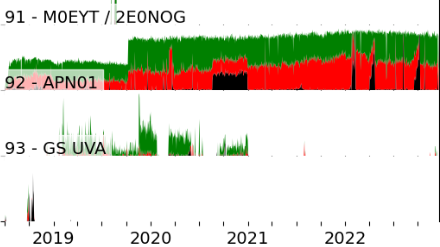

Pretty much full-tilt since the start of Q4, 2019.
We'll round this to 100% utilization and be comfortable with the result.

---

Since we are considering stations with a whole bunch of observations during the year, let's just ask the database.

In [35]:
%%sql
SELECT
    ground_station,
    count(id) AS num_obs
FROM times_index
WHERE start >= strftime("%s", "2022-01-01")
    AND start <  strftime("%s", "2023-01-01")
GROUP BY ground_station
ORDER BY num_obs DESC
LIMIT 10;

 * sqlite:///../data/observations.db
   sqlite:///../data/stations.db
Done.


ground_station,num_obs
6,67427
91,59955
766,58606
1864,54180
1936,45809
1126,44917
704,43908
2015,38615
901,37771
2029,33410


#91 is _only_ in second place, station #6 has 12% more observations!

Definitely need to see what the utilization was for these stations.
Fold the utilization calculation into the SQL while we're at it (just figured out common table expressions :).

In [36]:
%%sql
-- obs time for one station

WITH topten as (
    SELECT
        ground_station,
        count(id) AS num_obs,
        sum(end - start)/60.0 AS obs_min
    FROM times_index
    WHERE start >= strftime("%s", "2022-01-01")
        AND start <  strftime("%s", "2023-01-01")
    GROUP BY ground_station
    ORDER BY num_obs DESC
    )
SELECT
    ground_station,
    num_obs,
    round(obs_min, 1) as minutes,
    round(obs_min / (60*24*365) * 100, 1) AS "%", 
    round(obs_min / num_obs, 1) AS min_per_obs
FROM topten
ORDER BY minutes DESC
LIMIT 10;

 * sqlite:///../data/observations.db
   sqlite:///../data/stations.db
Done.


ground_station,num_obs,minutes,%,min_per_obs
766,58606,599340.8,114.0,10.2
91,59955,565239.5,107.5,9.4
1864,54180,557499.7,106.1,10.3
6,67427,554060.8,105.4,8.2
2015,38615,470562.1,89.5,12.2
1404,26768,448625.1,85.4,16.8
1936,45809,434865.1,82.7,9.5
2410,26278,434056.5,82.6,16.5
1126,44917,414250.7,78.8,9.2
704,43908,406346.7,77.3,9.3


So there are _four_ stations with better-than-perfect utilization?
The plot thickens and my curiosity on what the overlaps look like intensifies.

Another observation (LOL) is that the average duration of observations is not ordered in an obvious way.
Sorting by `min_per_obs` in the above query gives some stations with average durations of more than 15 minutes &mdash; which is odd because this is pushing the maximum time a satellite in LEO (around ISS altitude) is over a ground station.

Investigate a little more, station #2490 has the largest (by 2&times;) average observation time of 41 minutes.
What satellite is this?
Just query for all of the 16 observations and compute each duration.

In [37]:
%%sql
-- obs time for one station

SELECT
    id,
    ground_station,
    round((end - start)/60.0, 1) AS minutes
FROM times_index
WHERE ground_station = 2490
    AND start >= strftime("%s", "2022-01-01")
    AND start <  strftime("%s", "2023-01-01")
-- observation IDs are assigned when *scheduled*
-- NOT when the pass itself starts
ORDER BY start DESC;

 * sqlite:///../data/observations.db
   sqlite:///../data/stations.db
Done.


id,ground_station,minutes
5263869,2490,12.8
5263130,2490,8.5
5263357,2490,14.9
5263682,2490,8.5
5262843,2490,12.8
5263731,2490,12.8
5264184,2490,14.9
5263101,2490,12.8
5261803,2490,264.5
5254255,2490,14.9


Found them!
These specific observations of about 4 hours each are for Phase 3-B or AO-10, which is in a highly-elliptical orbit.

Other long duration (around 19 minutes) observations from other high-average stations was for situations where the GS did a small number of observations overall and were listening for satellites in high orbits (800+ km).

## Popular ground stations

Next is to explore the ground stations that were most popular according to users.
Popular in the sense that a diversity of people scheduled observations on the station.

We'll order by the most diversity and by number of observations, since the results are different.

In [38]:
%%sql
-- How many different observers have scheduled on each GS?
SELECT
    ground_station,
    count(distinct observer) as num_observers,
    count(id) AS num_obs
FROM times_index
WHERE start >= strftime("%s", "2022-01-01")
    AND start < strftime("%s", "2023-01-01")
GROUP BY ground_station
ORDER BY num_observers DESC
LIMIT 10;

 * sqlite:///../data/observations.db
   sqlite:///../data/stations.db
Done.


ground_station,num_observers,num_obs
None,54,8105
858,44,2364
183,41,1227
47,41,1706
2,40,2271
37,38,1506
1562,37,1190
657,37,6799
1698,36,1396
1663,36,2750


And the "winner" is `None`, or the totality of stations that had observations but where subsequently deleted from the Network.
Individual observations are archived, but any information about the station itself (such as position) is gone.

The next most popular station is [#858](https://network.satnogs.org/stations/858/) in Sweden, then a very "fat tail" of a distribution from then.
It isn't until about 250 stations down the list to drop below 10 different observers on a station.

Much of this is, I think, an effect of how one of the two web-based methods of scheduling on the Network works.
Clicking the "+ Schedule Observations" button takes you to https://network.satnogs.org/observations/new/ where the filtering is satellite-centric.
I.e. you first select a satellite and then select the stations to listen.
Selecting _all_ of the Online stations will then naturally create observations from one observer across many stations.

## Observer diversity

(don't have a good name for this)

Let's reverse the search to find the observers who have scheduled on the greatest number of stations.

In [39]:
%%sql
-- How many different GS have observers scheduled on?
SELECT
    observer,
    count(distinct ground_station) as num_gs,
    count(id) AS num_obs
FROM times_index
WHERE start >= strftime("%s", "2022-01-01")
    AND start < strftime("%s", "2023-01-01")
GROUP BY observer
ORDER BY num_gs DESC
LIMIT 20;

 * sqlite:///../data/observations.db
   sqlite:///../data/stations.db
Done.


observer,num_gs,num_obs
172,492,114450
173,450,35905
1996,323,20634
837,320,12871
1220,234,13455
3800,221,4467
2649,220,1798
3000,212,74776
2492,200,9178
2735,195,24612


Again, this is partially an effect of the "+ Schedule Observations" page behavior.

Since this query is somewhat a proxy for _user_ activity, we can see that there are a few handfulls of people who regularly schedule in a satellite-centric manner.

I think I show up on this list (1542) because I have re-started the intentional capturing of ARISS school contact downlinks, and therefore also occasionally do sat-focused scheduling across many ground stations.

## Popular satellites this year

In [40]:
%%sql
-- Which satellites are listened to by which GS?
--explain query plan
SELECT
    norad_cat_id as norad,
    count(distinct ground_station) as num_gs,
    count(id) AS num_obs
FROM times_index
WHERE start >= strftime("%s", "2022-01-01")
    AND start < strftime("%s", "2023-01-01")
GROUP BY norad
ORDER BY num_obs DESC
LIMIT 20;

 * sqlite:///../data/observations.db
   sqlite:///../data/stations.db
Done.


norad,num_gs,num_obs
33591,439,30233
28654,447,28435
25544,494,27271
40379,353,24944
25338,405,24515
48850,335,20859
40069,359,19534
40014,351,18594
47701,294,18010
48943,259,17506


> Dev note: the above query originally implicitly JOINed the `times_index` and `observations` tables to extract the `norad_cat_id` field from each observation.
That query took so long that I left it to run and went to bed, to find in the morning that it failed with an out-of-space (???) error.
So, I added `norad_cat_id` to the `times_index` R\* tree virtual table as an auxiliary column.
Now the query is back down to a few seconds.



This is a situation where we _do_ care about the names attached to the NORAD ID, since the only one I recognize easily is 25544 (ISS).
&rarr; Hit up the API for SatNOGS DB to pull this information.

Also fetch the launch date, so we can possibly handle popular satellites that launched in 2022 and not earlier.  This would affect the totals since it's a bit of a trick to observe a satellite before it launches :)

In [41]:
result = _

In [42]:
import requests
import requests_cache
from datetime import datetime, timedelta

# SatNOGS servers are >100 ms away from me,
# so this is as much for me as for them :)
requests_cache.install_cache(expire_after=60*60)

print('NORAD days name')
for norad, num_gs, num_obs in result:
    json = requests.get(f'https://db.satnogs.org/api/satellites/?norad_cat_id={norad}').json()
    name = json[0]['name']
    
    fakedate = ''
    if json[0]['launched'] is not None:
        launched = datetime.strptime(json[0]['launched'], "%Y-%m-%dT%H:%M:%SZ")
    else:
        # fake it
        launched = datetime(2022, 1, 1)
        fakedate = '*'

    time_operational = datetime(2023, 1, 1) - launched
    days_thisyear = min(timedelta(days=365), time_operational).days
    
    print(f'{norad} {days_thisyear} {name} {fakedate}')

NORAD days name
33591 365 NOAA 19 
28654 365 NOAA 18 
25544 365 ISS 
40379 365 GRIFEX 
25338 365 NOAA 15 
48850 365 RamSat 
40069 365 METEOR M-2 
40014 365 BUGSAT-1 
47701 365 Nanoconnect-2 
48943 365 QMR-KWT 
47959 365 GRBAlpha *
43199 365 SHAONIAN XING 
20442 365 LUSAT 
47438 365 UVSQ-SAT 
40043 365 TIGRISAT 
39090 365 STRAND-1 *
51085 352 VZLUSAT-2 
40968 365 BISONSAT 
39444 365 FUNCUBE-1 *
39469 365 MCUBED-2 *


NOAA weather satellites and the mighty International Space Station head the list, both categories are indeed perennially interesting to receive and very active.
Only one was launched this year.
No analysis to normalize to observations/day for other satellites launched this year in the query; a task for later. (i.e. &star;)

Another interesting note is that there are two satellites from the [Michigan eXploration Laboratory](https://exploration.engin.umich.edu/) (GRIFEX and MCUBED-2), started by Dr. James Cutler who can also be credited with one of the first loosely-coupled ground station networks.
The beginning of [this blog post by Bryan Klofas](https://www.klofas.com/blog/2020/satnogs-station-and-minicircuits-lna-modifications/) gives a nice overview of the "pre-SatNOGS era."

Speaking of MCubed, the one on this list is the re-flight of the original, which has an interesting story https://doi.org/10.1109/AERO.2013.6497127 (sorry, IEEE paywalled), also https://exploration.engin.umich.edu/blog/?p=1626 .


## Observers with satellite fever

The SatNOGS Network has enough of a geographic distribution of stations (lattitude specifically) that there is always a station to capture satellites in any orbit, not considering frequency capabilities.
Therefore, a user could potentially request observations for every satellite (with known orbital parameters) on some rotating basis.
In a way, this is the very goal of SatNOGS: to listen to all<sup>&dagger;</sup> satellites all the time.

<sup>&dagger;</sup> see https://wiki.satnogs.org/Spectrum_Management for our policy on what the resources of SatNOGS are intended to be primarily used for.

It mostly makes sense to listen to satellites which have `status == "alive"`.
How many are there in the DB?
This gives us the maximum number expected from the following query.

In [43]:
!curl --silent 'https://db.satnogs.org/api/satellites/?status=alive' | jq -c '.[]' | wc -l

847


In [44]:
%%sql
-- Which satellites are listened to by which GS?
--explain query plan
SELECT
    observer,
    count(distinct norad_cat_id) as num_sat,
    count(id) AS num_obs,
    round(1000.0*count(distinct norad_cat_id) / count(id), 1) as diversity
FROM times_index
WHERE start >= strftime("%s", "2022-01-01")
    AND start < strftime("%s", "2023-01-01")
GROUP BY observer
ORDER BY num_sat DESC
LIMIT 10;

 * sqlite:///../data/observations.db
   sqlite:///../data/stations.db
Done.


observer,num_sat,num_obs,diversity
172,658,114450,5.7
2012,576,19035,30.3
2533,540,11825,45.7
2740,528,91709,5.8
3462,527,31484,16.7
3000,513,74776,6.9
326,484,58961,8.2
969,453,1173,386.2
2401,448,24139,18.6
3223,441,37198,11.9


The `diversity` result column is the ratio of satellites to number of observations by the observer.
A larger number measures how consistently the observer listens to a variety of satellites.
A maximum diversity score of 1000 corresponds to a single observation per satellite.

For example, observer 969 scheduled relatively few observations in total, but were widely spread among satellites, to the tune of an average of less than 3 observations per satellite.

---

Next, let's take the same query but sort by the smallst `diversity` values.
This would be the observers that are focused on a single or small number of satelltes over many observations.
Note that this will also catch observers who simply schedule a _ton_ of observations.

In [45]:
%%sql
-- Which satellites are listened to by which GS?
--explain query plan
SELECT
    observer,
    count(distinct norad_cat_id) as num_sat,
    count(distinct ground_station) as num_gs,
    count(id) AS num_obs,
    round(1000.0*count(distinct norad_cat_id) / count(id), 1) as diversity
FROM times_index
WHERE start >= strftime("%s", "2022-01-01")
    AND start < strftime("%s", "2023-01-01")
GROUP BY observer
ORDER BY diversity ASC
LIMIT 25;

 * sqlite:///../data/observations.db
   sqlite:///../data/stations.db
Done.


observer,num_sat,num_gs,num_obs,diversity
3002,1,106,3947,0.3
750,11,1,6159,1.8
1984,1,2,447,2.2
3228,8,2,3717,2.2
792,11,3,4829,2.3
1891,2,1,830,2.4
1535,4,1,1592,2.5
2408,99,25,39978,2.5
1394,272,2,88821,3.1
1600,7,195,2193,3.2


A brief commentary on the "winners" of this query.

* Is it _bad_ to observe only one, or a small number of satellites?

A user can certainly be mostly interested in one or a few specific satellites!
We could ask who mostly is insterested in the NOAA weather satellites and little else, for example.
What observations to schedule on your own or others' station is entirely your perogative.

The questions splits into two considerations:

1. Observations on your own ground station.
2. Observations on others' ground stations.

(1) &mdash; it's your station, do with it as you wish.

(2) &mdash; Part of the **feature** of a network like SatNOGS, allowing free access to ground stations all over the world.
In the spirit of sharing, it is good to then also open your station up to scheduling by others as a contribution back to the community.  Indeed this is policy as codified in the [Network Permissions Matrix](https://wiki.satnogs.org/Operation#Network_Permissions_Matrix)

One grey area may be keeping your station in Testing mode continuously and scheduling many observations.
This incurs non-zero infrastructure cost for archiving the CC-BY-SA licensed results of these observations while not allowing others to schedule on the station.
Allowed behavior, but is debatible whether this is in the spirit of being part of a federated network.
_Note that this case is not captured in the above query_.

Another issue could be operating a low capability ground station maintained in Online status such that the user would then have unlimited ability, via the Permissions Matrix, to schedule many (many) observations on many ground stations.
Thus, having a relatively large ratio of capabilities used to capabilities donated.
For the most part, this has not been a problem across the Network and most users are hesitant to do massive amounts of scheduling.
Practically, this most affects stations with metered or limited Internet access and bandwidth.
There isn't really a good solution for this situation (start the conversation [in the forum](https://community.libre.space/) if you have ideas or have a station with these sorts of limitations).


## Stations watching all-the-sats

In the last section, there were no _observers_ who have listened for _every_ active satellite (847 in total).
What about ground stations?

In [46]:
%%sql
-- Which satellites are listened to by which GS?
--explain query plan
SELECT
    ground_station,
    count(distinct norad_cat_id) as num_sat,
    count(id) AS num_obs
FROM times_index
WHERE start >= strftime("%s", "2022-01-01")
    AND start < strftime("%s", "2023-01-01")
GROUP BY ground_station
ORDER BY num_sat DESC
LIMIT 10;

 * sqlite:///../data/observations.db
   sqlite:///../data/stations.db
Done.


ground_station,num_sat,num_obs
6,597,67427
91,559,59955
1534,547,7503
2733,541,8838
1864,532,54180
432,525,2162
1133,517,7492
1667,510,20448
2134,490,32137
2015,488,38615


No surprise that [station #6](https://network.satnogs.org/stations/6/) leads this list &mdash; it is owned by famous and prolific observer #172!

# More stats

I'm running out of steam, and time available to keep poking at this information with more questions.
Thus far we've not done any work looking at the **results** of observations for measures of real performance and efficiency.

Here's a list of other questions:

* Number of packets received from no-rotator vs. with-rotator stations.
* Density of packets received vs. local azimuth/elevation.
* Number of Good vs. Bad vetting results for no/with-rotator stations.
* Observations and success rates by frequency band.
* Packets decoded by declared `antenna_type`
* What about the stations with directional antennas in fixed orientations (no-rotator)?

## Your turn!

Want to tackle some of these questions or ask your own of the data?

Hopefully this notebook is self-contained enough that you can get started relatively quickly.
You'll just need a copy of the database of observations (`observations.db`) and perhaps the `stations.db` from the first section.

Contact me if you'd like a copy: dan.white at libre.space, it is about 17GB, and compresses down to 1.8GB (gzip) or 790MB (xz).

## Housekeeping

In [47]:
%%sql
PRAGMA optimize;

 * sqlite:///../data/observations.db
   sqlite:///../data/stations.db
Done.


optimize
